# Integrantes

- Sergio Orellana 221122
- Andre Marroquin 22266

## Instalación 

In [40]:
# ---- Importaciones principales y utilidades ----
import os                     # Operaciones del sistema de archivos y variables de entorno
from pathlib import Path      # Manejo de rutas de forma robusta y multiplataforma
import re                     # Expresiones regulares (para extraer fecha de nombres)
import numpy as np            # Cálculo numérico eficiente con arreglos
import matplotlib.pyplot as plt  # Visualización de datos

import rasterio               # Lectura/escritura de datos raster (geoespaciales)
from rasterio.enums import Resampling  # Tipos de remuestreo
from rasterio.mask import mask         # Recorte de raster con geometrías
from rasterio.warp import reproject, calculate_default_transform  # Reproyección/alineación

# Carga opcional de GeoPandas para soportar AOI por shapefile
try:
    import geopandas as gpd
    HAS_GPD = True            # Indicador de disponibilidad de GeoPandas
except Exception:
    HAS_GPD = False

from shapely.geometry import box, mapping  # Geometrías y conversión a mapeo para rasterio

from matplotlib.backends.backend_pdf import PdfPages  # Exportación a PDF (si se usa)

import pandas as pd

from rasterio.transform import array_bounds, xy
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS, Transformer


## Parámetros de ENTRADA (RUTAS, AOI, UMBRALES)

In [41]:
from pathlib import Path
import os

def _directorio_base():
    try:
        return Path(__file__).resolve().parent
    except NameError:
        return Path.cwd()

BASE_DIR = _directorio_base()
DATA_DIR = Path(os.environ.get("DATA_DIR", BASE_DIR)) 

AOI_MODE = "FULL"
AOI_BOX_BOUNDS = None
SHAPEFILE_PATH = None

def _resolver(ruta: str | Path, base: Path = DATA_DIR) -> Path:
    ruta = Path(ruta)
    return ruta if ruta.is_absolute() else (base / ruta)

B04_2020 = _resolver("2020-03-05-00_00_2020-03-05-23_59_Sentinel-2_L2A_B04_(Raw).tiff")
B08_2020 = _resolver("2020-03-05-00_00_2020-03-05-23_59_Sentinel-2_L2A_B08_(Raw).tiff")
B04_2024 = _resolver("2024-01-09-00_00_2024-01-09-23_59_Sentinel-2_L2A_B04_(Raw).tiff")
B08_2024 = _resolver("2024-01-09-00_00_2024-01-09-23_59_Sentinel-2_L2A_B08_(Raw).tiff")

LOSS_THRESHOLD = -0.2                 # Umbral de pérdida de NDVI
NDVI_VEG_THRESHOLD_2020 = 0.2         # Umbral NDVI para considerar vegetación en 2020

OUTDIR = _resolver("salidas_ndvi")    # Carpeta donde se guardarán resultados
OUTDIR.mkdir(parents=True, exist_ok=True)  # Crea carpeta (y padres) si no existen


In [42]:
# Abre un raster y devuelve un dataset rasterio
def LEER_RASTER(ALGO):
    return rasterio.open(ALGO)

# Extrae 'YYYY-MM-DD' del nombre del archivo; si no hay, devuelve 'FECHA_DESCONOCIDA'
def EXTRAER_FECHA_DESDE_NOMBRE(PATHLIKE):
    S = Path(PATHLIKE).name
    M = re.search(r"(\d{4}-\d{2}-\d{2})", S)
    return M.group(1) if M else "FECHA_DESCONOCIDA"

# Reproyecta y remuestrea SRC a la grilla/CRS del perfil de referencia
def ALINEAR_A_REFERENCIA(SRC_PATH, REF_PROFILE):
    with rasterio.open(SRC_PATH) as src:
        DEST = np.zeros((REF_PROFILE["height"], REF_PROFILE["width"]), dtype=np.float32)
        reproject(
            source=rasterio.band(src, 1),
            destination=DEST,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=REF_PROFILE["transform"],
            dst_crs=REF_PROFILE["crs"],
            resampling=Resampling.bilinear
        )
    return DEST

# Construye un perfil base (plantilla) para operaciones posteriores
def PERFIL_REFERENCIA(BASE_PATH):
    with rasterio.open(BASE_PATH) as src:
        PROFILE = src.profile.copy()
        PROFILE.update({
            "dtype": "float32",
            "count": 1,
            "compress": "deflate",
            "predictor": 2,
        })
    return PROFILE

# Recorta el raster a FULL/BOX/SHAPE; devuelve arreglo y perfil actualizado
def RECORTAR_AOI(DATA, PROFILE, AOI_MODE, AOI_BOX_BOUNDS=None, SHAPEFILE_PATH=None):
    if AOI_MODE == "FULL":
        return DATA, PROFILE

    if AOI_MODE == "BOX":
        if AOI_BOX_BOUNDS is None:
            raise ValueError("DEBES DEFINIR AOI_BOX_BOUNDS PARA MODO 'BOX'")
        GEOM = [mapping(box(*AOI_BOX_BOUNDS))]
    elif AOI_MODE == "SHAPE":
        if SHAPEFILE_PATH is None:
            raise ValueError("DEBES DEFINIR SHAPEFILE_PATH PARA MODO 'SHAPE'")
        if not HAS_GPD:
            raise ImportError("GEOPANDAS NO DISPONIBLE. INSTÁLALO O USA 'BOX'/'FULL'")
        GDF = gpd.read_file(SHAPEFILE_PATH)
        with rasterio.Env():
            with rasterio.open(PROFILE["transform"]) if False else None:
                pass
        GEOM = [mapping(g) for g in GDF.to_crs(PROFILE["crs"]).geometry]
    else:
        raise ValueError("AOI_MODE DESCONOCIDO")

    # Escribe en memoria para usar rasterio.mask y obtener recorte + nuevo transform
    with rasterio.io.MemoryFile() as MEM:
        with MEM.open(**PROFILE) as TMP:
            TMP.write(DATA.astype(np.float32), 1)
            OUT, OUT_TRANSFORM = mask(TMP, GEOM, crop=True, filled=True, nodata=np.nan)
            OUT = OUT[0]
            NEW_PROFILE = PROFILE.copy()
            NEW_PROFILE.update({
                "height": OUT.shape[0],
                "width": OUT.shape[1],
                "transform": OUT_TRANSFORM
            })
    return OUT, NEW_PROFILE

# Busca raster de calidad (SCL/QA60) que contenga la fecha en el nombre
def BUSCAR_CALIDAD(BASEDIR, FECHA):
    CANDIDATOS = list(BASEDIR.glob(f"*{FECHA}*SCL*.tif*")) + list(BASEDIR.glob(f"*{FECHA}*QA60*.tif*"))
    return CANDIDATOS[0] if CANDIDATOS else None

# Reproyecta la capa de calidad a la grilla de referencia y genera máscara de nubes
def MASCARA_NUBES_O_QA(QUALITY_PATH, REF_PROFILE):
    if QUALITY_PATH is None:
        return None
    with rasterio.open(QUALITY_PATH) as src:
        ARR = np.zeros((REF_PROFILE["height"], REF_PROFILE["width"]), dtype=np.float32)
        reproject(
            source=rasterio.band(src, 1),
            destination=ARR,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=REF_PROFILE["transform"],
            dst_crs=REF_PROFILE["crs"],
            resampling=Resampling.nearest
        )
    ARR = ARR.astype(np.int32)

    NAME = Path(QUALITY_PATH).name.upper()
    if "SCL" in NAME:
        CLOUD_CLASSES = {3, 8, 9, 10, 11}  # Clases nubes/sombra (Sentinel-2 SCL)
        MASK = np.isin(ARR, list(CLOUD_CLASSES)) 
    else:
        MASK = ARR > 0  # QA60: bitmask > 0 indica nubes
    return MASK


## Cargar, Alinear, Recortar y Aplicar Nubes

In [43]:
REF_PROFILE = PERFIL_REFERENCIA(B08_2020)  # Usa B08_2020 como grilla/CRS de referencia

B04_2020_ALIGNED = ALINEAR_A_REFERENCIA(B04_2020, REF_PROFILE) # Alinea RED 2020
B08_2020_ALIGNED = ALINEAR_A_REFERENCIA(B08_2020, REF_PROFILE) # Alinea NIR 2020
B04_2024_ALIGNED = ALINEAR_A_REFERENCIA(B04_2024, REF_PROFILE) # Alinea RED 2024
B08_2024_ALIGNED = ALINEAR_A_REFERENCIA(B08_2024, REF_PROFILE) # Alinea NIR 2024

B04_2020_CROP, CROP_PROFILE = RECORTAR_AOI(B04_2020_ALIGNED, REF_PROFILE, AOI_MODE, AOI_BOX_BOUNDS, SHAPEFILE_PATH)
B08_2020_CROP, CROP_PROFILE = RECORTAR_AOI(B08_2020_ALIGNED, CROP_PROFILE, AOI_MODE, AOI_BOX_BOUNDS, SHAPEFILE_PATH)
B04_2024_CROP, CROP_PROFILE = RECORTAR_AOI(B04_2024_ALIGNED, CROP_PROFILE, AOI_MODE, AOI_BOX_BOUNDS, SHAPEFILE_PATH)
B08_2024_CROP, CROP_PROFILE = RECORTAR_AOI(B08_2024_ALIGNED, CROP_PROFILE, AOI_MODE, AOI_BOX_BOUNDS, SHAPEFILE_PATH)

NODATA_MASK = (B04_2020_CROP == 0) | (B08_2020_CROP == 0) | (B04_2024_CROP == 0) | (B08_2024_CROP == 0)

FECHA_2020 = EXTRAER_FECHA_DESDE_NOMBRE(B04_2020)
FECHA_2024 = EXTRAER_FECHA_DESDE_NOMBRE(B04_2024)

INPUT_DIR_2020 = B04_2020.parent
INPUT_DIR_2024 = B04_2024.parent

Q_2020 = BUSCAR_CALIDAD(INPUT_DIR_2020, FECHA_2020)  # Busca SCL/QA60 por fecha 2020
Q_2024 = BUSCAR_CALIDAD(INPUT_DIR_2024, FECHA_2024)  # Busca SCL/QA60 por fecha 2024

# Máscaras de nubes por año (si existen capas de calidad)
CLOUD_2020 = MASCARA_NUBES_O_QA(Q_2020, CROP_PROFILE) if Q_2020 else None
CLOUD_2024 = MASCARA_NUBES_O_QA(Q_2024, CROP_PROFILE) if Q_2024 else None

# Máscara final por año (no-datos + nubes)
MASK_2020 = NODATA_MASK | (CLOUD_2020 if CLOUD_2020 is not None else False)
MASK_2024 = NODATA_MASK | (CLOUD_2024 if CLOUD_2024 is not None else False)


## Cálculo de NDVI, Diferencia y Máscara de Deforestación

In [44]:
# Calcula NDVI = (NIR - RED) / (NIR + RED), evitando /0 y aplicando máscara
def CALC_NDVI(NIR, RED, MASK):
    NIR = NIR.astype(np.float32)
    RED = RED.astype(np.float32)
    NUM = NIR - RED
    DEN = NIR + RED
    NDVI = np.divide(NUM, DEN, out=np.full_like(NUM, np.nan, dtype=np.float32), where=DEN!=0)
    NDVI[MASK] = np.nan
    return NDVI

NDVI_2020 = CALC_NDVI(B08_2020_CROP, B04_2020_CROP, MASK_2020)
NDVI_2024 = CALC_NDVI(B08_2024_CROP, B04_2024_CROP, MASK_2024)

NDVI_DIFF = NDVI_2024 - NDVI_2020   

# Pérdida: caída de NDVI por debajo del umbral y que en 2020 era vegetación
LOST_BOOL = (NDVI_DIFF < LOSS_THRESHOLD) & (NDVI_2020 > NDVI_VEG_THRESHOLD_2020)
LOST_BOOL[np.isnan(NDVI_DIFF) | np.isnan(NDVI_2020)] = False


## Cálculo de Áreas (% y ha)

In [45]:
VALID_MASK = ~np.isnan(NDVI_2020) & ~np.isnan(NDVI_2024)
LOSS_MASK = LOST_BOOL.astype(bool)

crs_src = CRS.from_user_input(CROP_PROFILE["crs"])
h, w = CROP_PROFILE["height"], CROP_PROFILE["width"]
cy, cx = h // 2, w // 2
cx_val, cy_val = xy(CROP_PROFILE["transform"], cy, cx)

to_latlon = Transformer.from_crs(crs_src, CRS.from_epsg(4326), always_xy=True)
lon_c, lat_c = to_latlon.transform(cx_val, cy_val)

def _utm_zone(lon):
    return int((lon + 180) // 6) + 1

zone = _utm_zone(lon_c)
crs_dst = CRS.from_epsg(32600 + zone) if lat_c >= 0 else CRS.from_epsg(32700 + zone)

bounds = array_bounds(h, w, CROP_PROFILE["transform"])
dst_transform, dst_w, dst_h = calculate_default_transform(
    crs_src, crs_dst, w, h, *bounds
)

dst_profile = CROP_PROFILE.copy()
dst_profile.update({
    "crs": crs_dst,
    "transform": dst_transform,
    "width": dst_w,
    "height": dst_h,
    "dtype": "uint8",
    "count": 1
})

def _reproyectar_bool(mask_bool, src_profile, dst_profile):
    src_arr = mask_bool.astype(np.uint8)
    dst_arr = np.zeros((dst_profile["height"], dst_profile["width"]), dtype=np.uint8)
    reproject(
        source=src_arr,
        destination=dst_arr,
        src_transform=src_profile["transform"],
        src_crs=src_profile["crs"],
        dst_transform=dst_profile["transform"],
        dst_crs=dst_profile["crs"],
        resampling=Resampling.nearest
    )
    return dst_arr.astype(bool)

VALID_MASK_UTM = _reproyectar_bool(VALID_MASK, CROP_PROFILE, dst_profile)
LOSS_MASK_UTM  = _reproyectar_bool(LOSS_MASK,  CROP_PROFILE, dst_profile)
VEG2020 = (NDVI_2020 > NDVI_VEG_THRESHOLD_2020) & ~np.isnan(NDVI_2020)
VEG2020_UTM = _reproyectar_bool(VEG2020, CROP_PROFILE, dst_profile)

PIXEL_WIDTH = abs(dst_profile["transform"].a)
PIXEL_HEIGHT = abs(dst_profile["transform"].e)
PIXEL_AREA_M2 = PIXEL_WIDTH * PIXEL_HEIGHT

AOI_AREA_M2 = VALID_MASK_UTM.sum() * PIXEL_AREA_M2
LOSS_AREA_M2 = LOSS_MASK_UTM.sum() * PIXEL_AREA_M2
VEG2020_AREA_M2 = VEG2020_UTM.sum() * PIXEL_AREA_M2

AOI_AREA_HA = AOI_AREA_M2 / 1e4
LOSS_AREA_HA = LOSS_AREA_M2 / 1e4
VEG2020_AREA_HA = VEG2020_AREA_M2 / 1e4

LOSS_PCT_AOI = 100.0 * (LOSS_AREA_M2 / AOI_AREA_M2) if AOI_AREA_M2 > 0 else np.nan
LOSS_PCT_SOBRE_VEG2020 = 100.0 * (LOSS_AREA_M2 / VEG2020_AREA_M2) if VEG2020_AREA_M2 > 0 else np.nan

RESUMEN = {
    "Fecha inicial": FECHA_2020,
    "Fecha final": FECHA_2024,
    "Umbral pérdida (ΔNDVI)": LOSS_THRESHOLD,
    "Umbral vegetación inicial": NDVI_VEG_THRESHOLD_2020,
    "Área por píxel (m²)": PIXEL_AREA_M2,
    "Área total AOI (ha)": AOI_AREA_HA,
    "Área pérdida (ha)": LOSS_AREA_HA,
    "% pérdida sobre AOI": LOSS_PCT_AOI,
    "Área vegetación inicial (ha)": VEG2020_AREA_HA,
    "% pérdida sobre vegetación inicial": LOSS_PCT_SOBRE_VEG2020,
}

df_resumen = pd.DataFrame(
    [{"Métrica": k, "Valor": v} for k, v in RESUMEN.items()]
)
display(df_resumen)

print(
    f"Entre {FECHA_2020} y {FECHA_2024}, con ΔNDVI ≤ {LOSS_THRESHOLD} y vegetación inicial NDVI>{NDVI_VEG_THRESHOLD_2020}, "
    f"la pérdida estimada es {LOSS_PCT_AOI:.2f}% del AOI (≈ {LOSS_AREA_HA:.2f} ha) "
    f"y {LOSS_PCT_SOBRE_VEG2020:.2f}% sobre la vegetación inicial."
)


,Métrica,Valor
0,Fecha inicial,2020-03-05
1,Fecha final,2024-01-09
2,Umbral pérdida (ΔNDVI),-0.2
3,Umbral vegetación inicial,0.2
4,Área por píxel (m²),9452.329579
5,Área total AOI (ha),3392973.251901
6,Área pérdida (ha),48004.600998
7,% pérdida sobre AOI,1.414824
8,Área vegetación inicial (ha),3343458.168637
9,% pérdida sobre vegetación inicial,1.435777


Entre 2020-03-05 y 2024-01-09, con ΔNDVI ≤ -0.2 y vegetación inicial NDVI>0.2, la pérdida estimada es 1.41% del AOI (≈ 48004.60 ha) y 1.44% sobre la vegetación inicial.


Entre el 5 de marzo de 2020 y el 9 de enero de 2024, el análisis comparativo de NDVI muestra una pérdida estimada del 1.41 % del área total analizada (AOI), lo que equivale aproximadamente a 48 004.60 hectáreas. Cuando esta pérdida se evalúa únicamente sobre la superficie que ya estaba cubierta por vegetación en 2020 (NDVI > 0.2), el porcentaje se incrementa ligeramente a 1.44 %, lo que indica que la mayor parte de la deforestación o degradación detectada afecta zonas que originalmente eran vegetadas.

El área de interés total alcanza alrededor de 3.39 millones de hectáreas, con una cobertura inicial de vegetación en 2020 de 3.34 millones de hectáreas, lo que evidencia que casi la totalidad del AOI estaba cubierta por vegetación al inicio del período de estudio. El umbral utilizado para definir pérdida (ΔNDVI ≤ −0.2) permite captar cambios significativos en la salud y densidad de la vegetación, minimizando la detección de variaciones menores que podrían deberse a factores estacionales o ruido en los datos.

La magnitud absoluta de la pérdida, aunque porcentualmente baja, representa un impacto considerable en términos de superficie. El hecho de que el porcentaje sobre vegetación inicial y sobre el AOI sean tan similares confirma que el AOI es altamente vegetado y que las áreas de cambio se distribuyen de forma relativamente uniforme dentro de esa cobertura. 

##  Visualizaciones solicitadas

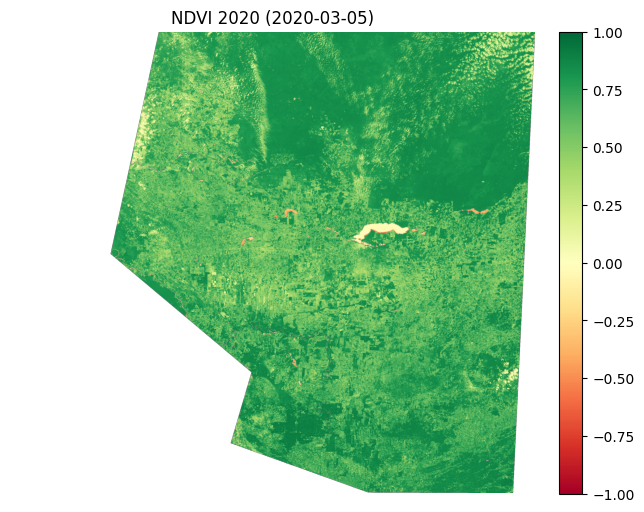

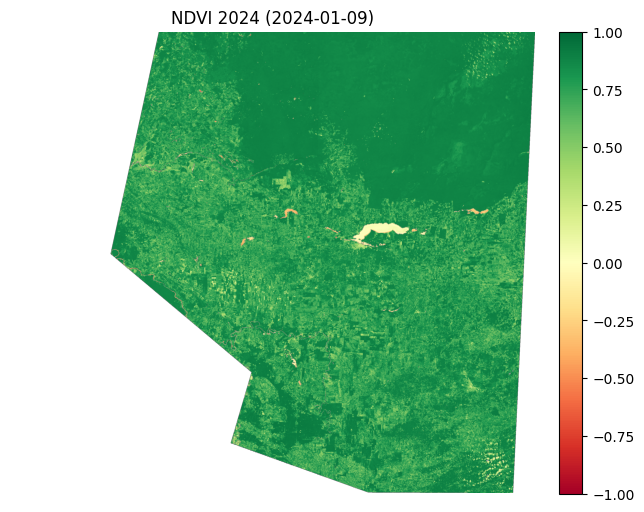

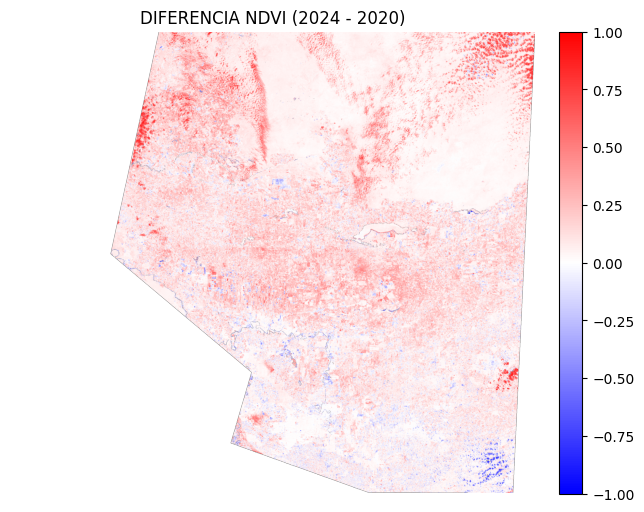

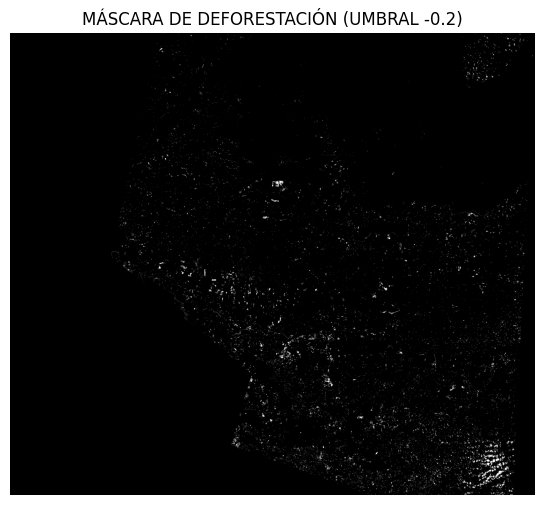

In [46]:
# NDVI 2020
plt.figure(figsize=(8,6))
IM = plt.imshow(NDVI_2020, vmin=-1, vmax=1, cmap="RdYlGn")
plt.title(f"NDVI 2020 ({FECHA_2020})")
plt.colorbar(IM, fraction=0.046, pad=0.04)
plt.axis("off")
plt.show()

# NDVI 2024
plt.figure(figsize=(8,6))
IM = plt.imshow(NDVI_2024, vmin=-1, vmax=1, cmap="RdYlGn")
plt.title(f"NDVI 2024 ({FECHA_2024})")
plt.colorbar(IM, fraction=0.046, pad=0.04)
plt.axis("off")
plt.show()

# DIFERENCIA (2024 - 2020)
plt.figure(figsize=(8,6))
IM = plt.imshow(NDVI_DIFF, vmin=-1, vmax=1, cmap="bwr")
plt.title("DIFERENCIA NDVI (2024 - 2020)")
plt.colorbar(IM, fraction=0.046, pad=0.04)
plt.axis("off")
plt.show()

# MÁSCARA DE DEFORESTACIÓN
plt.figure(figsize=(8,6))
IM = plt.imshow(LOST_BOOL, cmap="gray")
plt.title(f"MÁSCARA DE DEFORESTACIÓN (UMBRAL {LOSS_THRESHOLD})")
plt.axis("off")
plt.show()


En la primera imagen, correspondiente al NDVI 2020, se observa un paisaje predominantemente verde con valores altos de índice, lo que indica una cobertura vegetal densa y saludable en la mayor parte del Área de Interés (AOI). La presencia de tonos verdes intensos sugiere vegetación vigorosa, mientras que pequeñas zonas en tonos más claros o amarillos corresponden a áreas menos densamente cubiertas, posiblemente agrícolas, zonas urbanas o cuerpos de agua.

En la segunda imagen, que representa el NDVI 2024, la cobertura vegetal sigue siendo mayoritaria, pero se aprecian ligeros cambios en algunas zonas, especialmente en sectores que muestran un tono verde menos intenso. Estos cambios pueden estar asociados a procesos de deforestación, degradación o cambio de uso de suelo.

La tercera imagen, que muestra la diferencia de NDVI (2024 - 2020), es clave para la detección de cambios ya que, las áreas en rojo evidencian disminución del índice y, por tanto, pérdida de vigor o cobertura vegetal, mientras que las áreas en azul representan incrementos de NDVI. El patrón predominante de color rojo en diversas zonas confirma la existencia de una pérdida generalizada, aunque no extrema, en distintos puntos del AOI. Este mapa pone de relieve áreas críticas donde se concentran las reducciones más significativas de Petén.

Finalmente, la máscara de deforestación con umbral ΔNDVI ≤ -0.2 destaca de forma binaria las zonas donde la pérdida ha superado el umbral definido, filtrando cambios menores y enfocándose en áreas de impacto más marcado. Las manchas blancas en este mapa señalan los lugares específicos donde se ha producido deforestación o degradación relevante, distribuidas de manera dispersa pero con cierta concentración en el centro y sur del AOI.

## Exportar GeoTIFFs (NDVI, Diferencia, Máscara)

In [47]:
def GUARDAR_GEOTIFF(ARRAY, PROFILE, OUTPATH, DTYPE="float32", NODATA=np.nan):
    PROFILE = PROFILE.copy()
    PROFILE.update({"dtype": DTYPE, "count": 1, "nodata": NODATA})
    with rasterio.open(OUTPATH, "w", **PROFILE) as dst:
        if np.issubdtype(ARRAY.dtype, np.floating) and np.isnan(NODATA):
            dst.write(ARRAY.astype(np.float32), 1)
        else:
            dst.write(ARRAY.astype(PROFILE["dtype"]), 1)

# RUTAS
OUT_NDVI_2020 = OUTDIR / "NDVI_2020.tif"
OUT_NDVI_2024 = OUTDIR / "NDVI_2024.tif"
OUT_DIFF = OUTDIR / "NDVI_DIFF_2024_MINUS_2020.tif"
OUT_MASK = OUTDIR / "DEFORESTACION_MASK.tif"

GUARDAR_GEOTIFF(NDVI_2020, CROP_PROFILE, OUT_NDVI_2020, "float32", np.nan)
GUARDAR_GEOTIFF(NDVI_2024, CROP_PROFILE, OUT_NDVI_2024, "float32", np.nan)
GUARDAR_GEOTIFF(NDVI_DIFF, CROP_PROFILE, OUT_DIFF, "float32", np.nan)
GUARDAR_GEOTIFF(LOST_BOOL.astype(np.uint8), CROP_PROFILE, OUT_MASK, "uint8", 0)

print("GEOTIFFS GUARDADOS EN:", OUTDIR)


GEOTIFFS GUARDADOS EN: c:\Users\sergi\OneDrive - mazariegos.io 1\Sergio Orellana\Data Science\Lab3-DS\salidas_ndvi


# Conclusión

En el período comprendido entre el 5 de marzo de 2020 y el 9 de enero de 2024, el área de interés experimentó cambios detectables en su cobertura vegetal. A partir del análisis de NDVI, se determinó que la vegetación inicial se encontraba en buen estado, cubriendo casi la totalidad del territorio evaluado. Sin embargo, al final del período, se identificaron zonas con disminución significativa en los valores del índice, lo que evidenció procesos de deforestación o degradación en puntos específicos.

La comparación espacial reveló que, aunque la pérdida porcentual fue relativamente baja en relación con el total del AOI (1.41 %), la magnitud absoluta de la superficie afectada alcanzó alrededor de 48 004 hectáreas. La mayoría de estas pérdidas se concentraron en áreas previamente cubiertas por vegetación, lo que sugirió una alteración directa en ecosistemas consolidados más que en áreas ya intervenidas. Además, la distribución de las zonas afectadas indicó patrones dispersos, con focos localizados en ciertas regiones del centro y sur del territorio.

Por lo que, el análisis confirmó que, a pesar de que la cobertura vegetal general se mantuvo mayoritariamente estable, existieron impactos notables en áreas específicas que debieron ser objeto de atención prioritaria. Lo cual este resultado nos permitió no solo dimensionar la magnitud de la pérdida, sino también establecer una base para futuras estrategias de monitoreo y gestión orientadas a la conservación y recuperación de las zonas degradadas.